In [10]:
# Import common GIS tools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
from odc.stac import stac_load

In [11]:
def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

def get_box(lat, lon, box_size):
    min_lon = lon-box_size/2
    min_lat = lat-box_size/2
    max_lon = lon+box_size/2
    max_lat = lat+box_size/2
    return (min_lon, min_lat, max_lon, max_lat)

In [12]:
df = pd.read_csv("data/Crop_Location_Data.csv")
lat_longs = []
for cc in df["Latitude and Longitude"]:
    latlong = cc.replace('(','').replace(')','').replace(' ','').split(',')
    lat_longs.append((float(latlong[0]), float(latlong[1])))

In [23]:
lat_long = lat_longs[0]
lat_long = [10.27819073690894, 105.31822315786805]
box_size_deg = 0.002
time_window="2022-01-01/2022-1-31"
resolution = 1
scale = resolution / 111320.0
bounds = get_box(lat_long[0], lat_long[1], box_size_deg)

In [24]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(collections=["sentinel-2-l2a"], bbox=bounds, datetime=time_window)
items = list(search.get_all_items())
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)

In [25]:
search = stac.search(collections=["sentinel-1-rtc"], bbox=bounds, datetime=time_window)
items = list(search.get_all_items())
xx2 = stac_load(
    items,
    bands=["vv", "vh"],
    crs="EPSG:4326",
    resolution=scale,
    patch_url=pc.sign,
    bbox=bounds
)

In [26]:
# 7 high RVI, 17 low RVI
time = 1

In [ ]:
plt.style.use('dark_background')

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


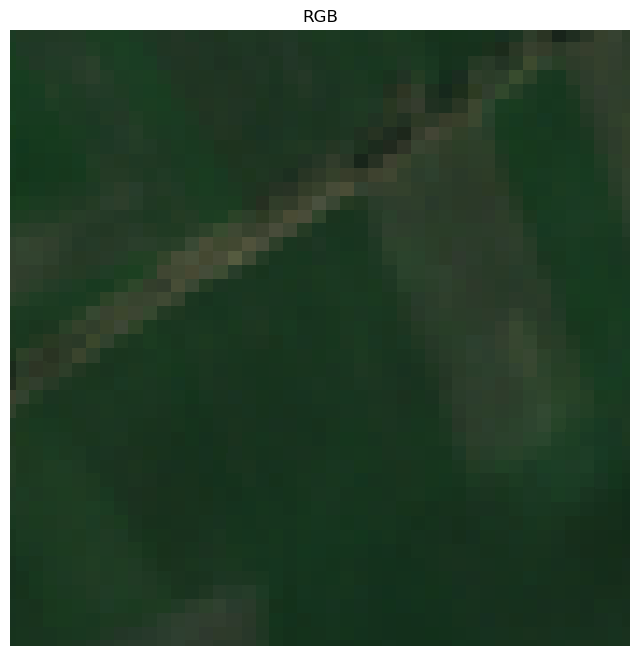

In [27]:
import matplotlib.patches as patches
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=3000)
ax.set_title("RGB")
ax.axis('off')
plt.show()

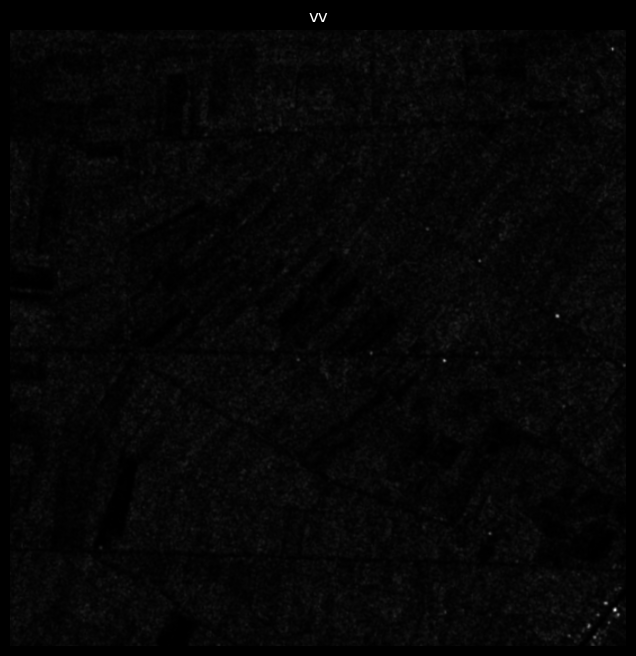

In [93]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(xx2.isel(time=time)["vv"].to_numpy(), cmap='gray')
ax.set_title("vv")
ax.axis('off')
plt.show()

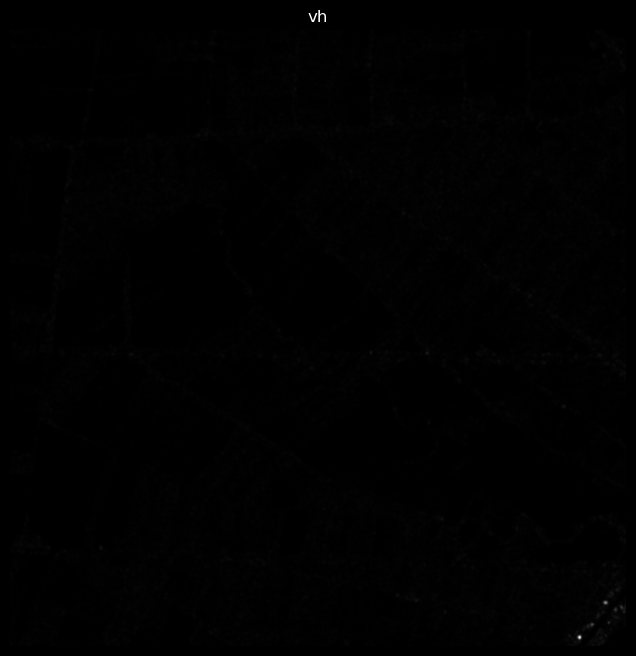

In [94]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(xx2.isel(time=time)["vh"].to_numpy(), cmap='gray')
ax.set_title("vh")
ax.axis('off')
plt.show()

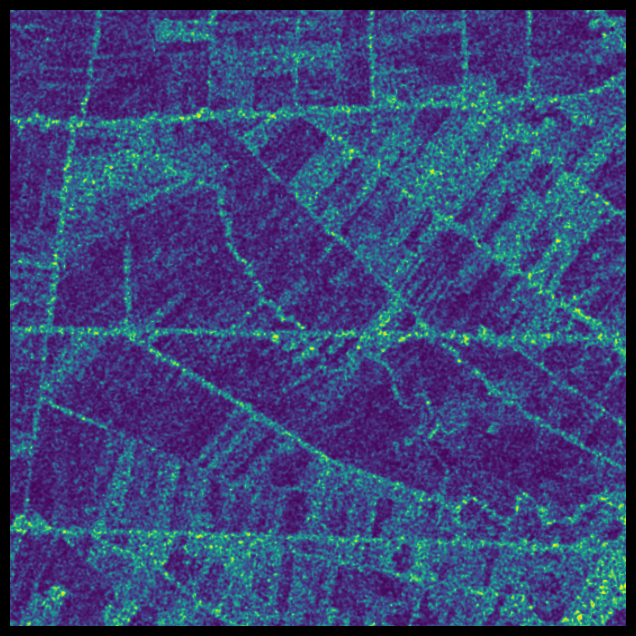

In [125]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
vv = xx2.isel(time=time)["vv"].to_numpy()
vh = xx2.isel(time=time)["vh"].to_numpy()
rvi = np.sqrt((vv / (vv + vh)))*((4*vh)/(vv + vh))
plt.imshow(rvi)
ax.set_title("RVI")
ax.axis('off')
plt.show()

In [44]:
print("Mean RVI: {}".format(rvi.mean()))

Mean RVI: 0.33427444100379944
